In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import matplotlib.image as image
from torchvision.datasets import ImageFolder
from torchsummary import summary
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive')

transform_train = transforms.Compose([transforms.ToTensor(),])
# transform_train = transforms.Compose([transforms.ToTensor(), transforms.Resize((64, 64)),])
train_dataset = ImageFolder(root='/content/gdrive/My Drive/Training', transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = ImageFolder(root='/content/gdrive/My Drive/Test', transform=transform_train)
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

print(train_dataset)
print(test_dataset)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Dataset ImageFolder
    Number of datapoints: 1600
    Root location: /content/gdrive/My Drive/Training
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 400
    Root location: /content/gdrive/My Drive/Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


Train - image batch dimensions: torch.Size([64, 3, 256, 256])
Train - image label dimensions: torch.Size([64])
Test - image batch dimensions: torch.Size([64, 3, 256, 256])
Test - image label dimensions: torch.Size([64])


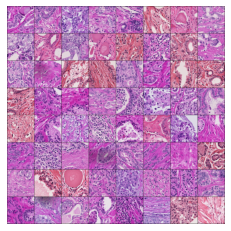

In [64]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

for images, labels in train_loader: # print(images.shape)
    print("Train - image batch dimensions:", images.shape)
    print("Train - image label dimensions:", labels.shape)
    break

for images, labels in test_loader: # print(labels.shape)
    print("Test - image batch dimensions:", images.shape)
    print("Test - image label dimensions:", labels.shape)
    break

images_grid = torchvision.utils.make_grid(images)
plt.imshow(np.transpose(images_grid.numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [65]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = models.resnet18(pretrained=True) # load the existing model (Resnet18) pretrained model: use weights from ImageNet dataset(선 학습된 weight 가져온다.)
model_ft = model_ft.to(device)
# print(model_ft)
summary(model_ft, input_size=(3,256,256))  # 진행될수록 channel은 늘고, pooling하기 때문에 가로세로는 줄어든다. 마지막에 1000이 되는 이유는, imagenet class가 1000개여서

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [66]:
fc_num_in_fts = model_ft.fc.in_features
model_ft.fc = nn.Linear(fc_num_in_fts, 4) # .Linear : fully-connected layer / in 512, out 10으로 수정된 새로운 layer를 넣어준다.

model_ft = model_ft.to(device)
summary(model_ft, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [67]:
## compute stat
def compute_stat(outputs, labels, stats):
    _, preds = torch.max(outputs, 1) # 가장 큰 값을 찾아냄
    stats['n_corr'] += torch.sum(preds == labels).item() # dict의 key와 value 쌍을 얻을 수 있다.
    stats['n'] += torch.numel(labels) # input tensor의 총 요소 수를 반환합니다

    return stats

def train_model(model, criterion, optimizer, trainloader, device, num_epochs=25):
  epoch_stat = {'n_corr': 0, 'n': 0}

  for epoch in range(num_epochs):
      train_running_loss = 0.0
      train_acc = 0.0

      model.train()  # Set model to training mode

      ## training step / batch 하나씩 처리하는 for문
      for i, (images, labels) in enumerate(trainloader):
          
          images = images.to(device) # cpu에서 gpu로 data 넘김
          labels = labels.to(device)

          ## forward + backprop + loss
          optimizer.zero_grad() # grdient 계산된 것이 optimizer에 더해지는 방식으로 계산되는데, 새로운 배치에서는 초기 상태로 만들어줘야 한다.
          outputs = model(images) # feed forward
          loss = criterion(outputs, labels) # 오차 = 어떻게 계산할껀지 정한거(예측치, 실제 정답)
          loss.backward() # loss에 따라 gradient가 계산됨

          ## update model params
          optimizer.step() # weight 값들이 조절됨

          train_running_loss += loss.detach().item() # detach() 메서드는 그래디언트가 필요하지 않다고 선언된 텐서에 새 뷰를 생성. 에러값이 어떻게 계산되었는지 확인하기위해 더하주고 있음
          epoch_stat = compute_stat(outputs, labels, epoch_stat) # 얼마나 정답인지 등 stat 표기.
      
      model.eval() # evaluation(평가) mode로 전환
      print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
            %(epoch, train_running_loss / i, epoch_stat['n_corr'] / epoch_stat['n'] * 100))
      
      test_stat = {'n_corr': 0, 'n': 0}
      for i, (images, labels) in enumerate(test_loader, 0):
          images = images.to(device)
          labels = labels.to(device)
          outputs = model_ft(images)
          test_stat = compute_stat(outputs, labels, test_stat)
            
      print('Test Accuracy: %.2f'%( test_stat['n_corr'] / test_stat['n'] * 100))
      
  return model

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 마지막 layer는 우리가 class를 1000개에서 4개로 줄였기 때문에 weight 값이 임의로 설정되어있다. = 학습을 다시 해야함.(앞에서 사용한 model을 이용해보자)
criterion_ft = nn.CrossEntropyLoss() # loss function
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1e-2, momentum=0.9)
model_ft = train_model(model_ft, criterion_ft, optimizer_ft, train_loader, device, num_epochs=10)

Epoch: 0 | Loss: 1.0537 | Train Accuracy: 56.50
Test Accuracy: 66.12
Epoch: 1 | Loss: 0.3838 | Train Accuracy: 70.56
Test Accuracy: 92.75
Epoch: 2 | Loss: 0.1330 | Train Accuracy: 78.94
Test Accuracy: 97.56
Epoch: 3 | Loss: 0.0321 | Train Accuracy: 84.09
Test Accuracy: 99.94
Epoch: 4 | Loss: 0.0141 | Train Accuracy: 87.24
Test Accuracy: 99.94
Epoch: 5 | Loss: 0.0052 | Train Accuracy: 89.35
Test Accuracy: 99.94
Epoch: 6 | Loss: 0.0028 | Train Accuracy: 90.88
Test Accuracy: 100.00
Epoch: 7 | Loss: 0.0016 | Train Accuracy: 92.02
Test Accuracy: 100.00
Epoch: 8 | Loss: 0.0012 | Train Accuracy: 92.90
Test Accuracy: 100.00
Epoch: 9 | Loss: 0.0007 | Train Accuracy: 93.61
Test Accuracy: 100.00


In [68]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # 마지막 layer는 우리가 class를 1000개에서 4개로 줄였기 때문에 weight 값이 임의로 설정되어있다. = 학습을 다시 해야함.(앞에서 사용한 model을 이용해보자)
criterion_ft = nn.CrossEntropyLoss() # loss function
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)
model_ft = train_model(model_ft, criterion_ft, optimizer_ft, train_loader, device, num_epochs=10)

Epoch: 0 | Loss: 0.9105 | Train Accuracy: 62.56
Test Accuracy: 77.69
Epoch: 1 | Loss: 0.2651 | Train Accuracy: 78.31
Test Accuracy: 99.56
Epoch: 2 | Loss: 0.0760 | Train Accuracy: 85.46
Test Accuracy: 100.00
Epoch: 3 | Loss: 0.0226 | Train Accuracy: 89.08
Test Accuracy: 100.00
Epoch: 4 | Loss: 0.0128 | Train Accuracy: 91.26
Test Accuracy: 100.00
Epoch: 5 | Loss: 0.0066 | Train Accuracy: 92.72
Test Accuracy: 100.00
Epoch: 6 | Loss: 0.0055 | Train Accuracy: 93.76
Test Accuracy: 100.00
Epoch: 7 | Loss: 0.0040 | Train Accuracy: 94.54
Test Accuracy: 100.00
Epoch: 8 | Loss: 0.0035 | Train Accuracy: 95.15
Test Accuracy: 100.00
Epoch: 9 | Loss: 0.0031 | Train Accuracy: 95.63
Test Accuracy: 100.00
